In [1]:
%run setup.ipynb

Path setup complete.


# Solvers and Schemes

There are multiple solvers which solve a problem with respect to at least one variable between saturation and pressure and numerical schemes which solve the whole pressure plus saturation problem. 

Solvers: 
- Implicit Pressure solver (IMP), 
- Implicit Saturation Solver (IMS)  
- Explicit Saturation Solver (ES)
- Fully Implicit: Solve pressure and saturation simultaeneously

Schemes: 
- IMPES: Implicit pressure solver + Explicit Saturation solver 
- IMPIMS: Implicit Pressure solver + Implicit Saturation solver 
- SOLSS: Based on Fully Implicit solver 

## Set up initial problem

In [7]:
import numpy as np
import yads.mesh as ym
from yads.wells import Well


In [13]:
# Define grid
grid = ym.two_D.create_2d_cartesian(Lx=21, Ly=5, Nx=21, Ny=5)

In [34]:
# Properties 
# Porosity
phi = np.full(grid.nb_cells, 0.2)
# Diffusion coefficient (i.e Permeability)
K = np.full(grid.nb_cells, 100.0e-15)
# viscosity
mu_w = 0.571e-3
mu_g = 0.0285e-3
# Relative permeability model: only 'cross' (kr(s) = s) and 'quadratic' (kr(s) = s**2) are supported 
kr_model = "quadratic"

In [35]:
# BOUNDARY CONDITIONS #
# Pressure
# Small pressure gradient from left to right
Pb = {"left": 110.0e5,  "right": 100.0e5}
# Saturation
# Inject gaz from left to right through Dirichlet boundary conditions
Sb_d = {"left": 1.0, "right": 0.0}
# No Neumann so we create a dict of None
Sb_n = {"left": None, "right": None}
Sb_dict = {"Dirichlet": Sb_d, "Neumann": Sb_n}

In [36]:
from yads.numerics.physics import calculate_transmissivity
# Compute face transmitivity based on mesh geometry and permeability
T = calculate_transmissivity(grid=grid, K=K)

## Solvers 

In [81]:
from yads.numerics.solvers import solss_solver, explicit_saturation_solver, implicit_pressure_solver, implicit_saturation_solver

In [82]:
import matplotlib.pyplot as plt

### IMP: Implicit pressure solver 
Solve the pressure problem. In the context of incompressible two-phase flow in porous medium model, pressure behaves in an elliptic linear fashion way. Therefore, solving the pressure problem requires to solve a linear system of equation and the resulting implicit pressure is just a linear approximation between boundary conditions (well can be seen as an inside domain boundary condition, inner condition? )

In [83]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does not matter too much 
P = np.full(grid.nb_cells, 100.0e5)

Pimp = implicit_pressure_solver(
                        grid=grid, 
                        K=K,
                        T=T, 
                        P=P,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict, 
                        mu_g=mu_g,
                        mu_w=mu_w,
                        wells=[],
                        kr_model=kr_model
                    )

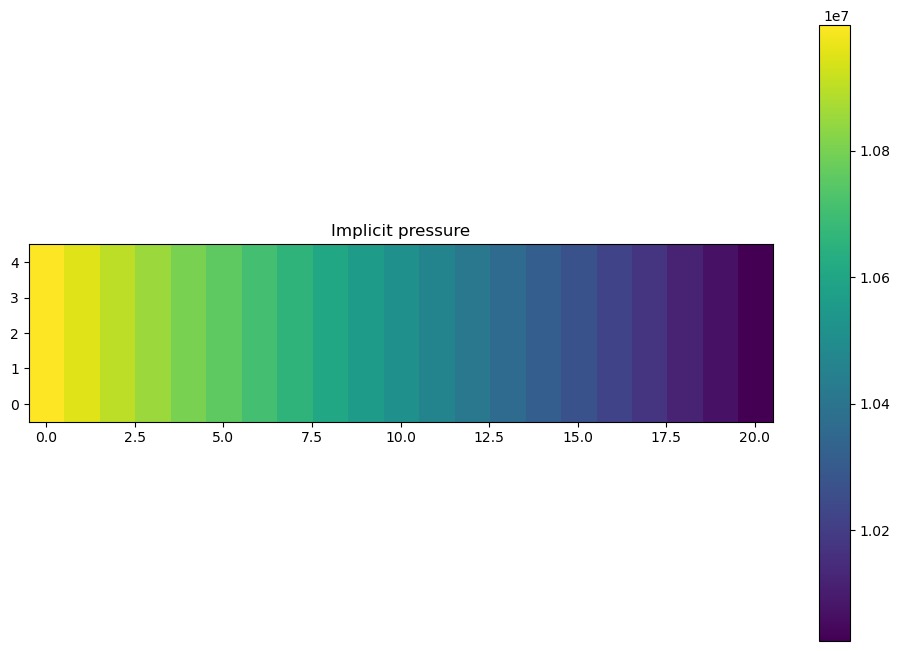

In [84]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
im = ax1.imshow(Pimp.reshape(21, 5).T)
ax1.invert_yaxis()
ax1.set_title("Implicit pressure")
plt.colorbar(im)
plt.show()

### ES: Explicit Saturation solver (Not up to date need good refactoring)

The main non-linearities arise through the saturation as it behave in a non-linear hyperbolic fashion.

In [104]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does matter a lot ! 
P = np.full(grid.nb_cells, 100.0e5)
# timestep in seconds 
dt = 1.
S_exp, F, F_well = explicit_saturation_solver(
                        grid=grid, 
                        K=K,
                        phi=phi, 
                        T=T, 
                        P=Pimp,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict,
                        dt=dt,
                        mu_o=mu_g,
                        mu_w=mu_w,
                        wells=[],
                    )

In [105]:
from yads.numerics.numerical_tests import cfl_condition
from yads.physics.fractional_flow import dfw_dsw
cfl, _ = cfl_condition(grid=grid, 
              phi=phi, 
              Pb=Pb,
              F=F, 
              F_well=F_well, 
              dfw=dfw_dsw, 
              mu_o=mu_g, 
              mu_w=mu_w, 
              wells=[])


In [106]:
print(cfl)

23438.500042634398


In [111]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does matter a lot ! 
P = np.full(grid.nb_cells, 100.0e5)
# timestep in seconds 
dt = 0.9 * cfl
S_exp, F, F_well = explicit_saturation_solver(
                        grid=grid, 
                        K=K,
                        phi=phi, 
                        T=T, 
                        P=Pimp,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict,
                        dt=dt,
                        mu_o=mu_g,
                        mu_w=mu_w,
                        wells=[],
                    )

In [112]:
S_exp

array([0.00449365, 0.00449365, 0.00449365, 0.00449365, 0.00449365,
       0.00404411, 0.00404411, 0.00404411, 0.00404411, 0.00404411,
       0.00363955, 0.00363955, 0.00363955, 0.00363955, 0.00363955,
       0.00327545, 0.00327545, 0.00327545, 0.00327545, 0.00327545,
       0.00294778, 0.00294778, 0.00294778, 0.00294778, 0.00294778,
       0.00265289, 0.00265289, 0.00265289, 0.00265289, 0.00265289,
       0.0023875 , 0.0023875 , 0.0023875 , 0.0023875 , 0.0023875 ,
       0.00214866, 0.00214866, 0.00214866, 0.00214866, 0.00214866,
       0.00193371, 0.00193371, 0.00193371, 0.00193371, 0.00193371,
       0.00174026, 0.00174026, 0.00174026, 0.00174026, 0.00174026,
       0.00156617, 0.00156617, 0.00156617, 0.00156617, 0.00156617,
       0.00140949, 0.00140949, 0.00140949, 0.00140949, 0.00140949,
       0.00126849, 0.00126849, 0.00126849, 0.00126849, 0.00126849,
       0.00114159, 0.00114159, 0.00114159, 0.00114159, 0.00114159,
       0.00102739, 0.00102739, 0.00102739, 0.00102739, 0.00102

### IMS: Implicit Saturation solver

In [87]:
# gaz saturation initialization: Only water at first 
S = np.full(grid.nb_cells, 0.0)
# Pressure initialization: Initial pressure guess, does matter a lot ! 
P = np.full(grid.nb_cells, 100.0e5)
dt = 1.
S_imp, dt, step = implicit_saturation_solver(
                        grid=grid,
                        phi=phi,
                        T=T, 
                        P=P,
                        S=S,
                        Pb=Pb,
                        Sb_dict=Sb_dict,
                        dt=dt,
                        mu_g=mu_g,
                        wells=[],
                    )

norm: 7.85E-02
norm: 0.00E+00


In [88]:
S_imp

array([0.03508772, 0.03508772, 0.03508772, 0.03508772, 0.03508772,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

## Schemes 

### IMPES

### IMPIMS

### SOLLS (Fully Implicit)